### 1. Data preparation

##### 1.1. Dataset from Kaggle:

In [1]:
import kagglehub

# Download latest version
data_dir = kagglehub.dataset_download("andrewmvd/dog-and-cat-detection")

print("Path to dataset files:", data_dir)

Path to dataset files: C:\Users\admin\.cache\kagglehub\datasets\andrewmvd\dog-and-cat-detection\versions\1


##### 1.2. Create dataset:

In [13]:
from torch.utils.data import Dataset
import os
from xml.etree import ElementTree as ET
from PIL import Image
import torch

class ImageDataset(Dataset):
    def __init__(self, image_dir, annotation_dir, transform=None):
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.transform = transform
        self.image_files = self._filter_images_with_single_object()

    def _filter_images_with_single_object(self):
        valid_image_files = []
        for file in os.listdir(self.image_dir):
            if os.path.isfile(os.path.join(self.image_dir, file)):
                image_name = file
                annotation_name = os.path.splitext(image_name)[0] + '.xml'
                annotation_path = os.path.join(self.annotation_dir, annotation_name)

                if self._count_object_in_annotation(annotation_path) <= 1:
                    valid_image_files.append(image_name)
                else:
                    print(f'Image {image_name} has more than 1 object and will be excluded from dataset.')
        return valid_image_files
    
    def _count_object_in_annotation(self, annotation_path):
        try:
            tree = ET.parse(annotation_path)
            root = tree.getroot()
            count = 0
            for obj in root.findall('object'):
                count += 1
            return count
        except FileNotFoundError:
            return 0

    def _parse_annotation(self, annotation_path):
        try:
            tree = ET.parse(annotation_path)
            root = tree.getroot()
            image_width = int(root.find('size/width').text)
            image_height = int(root.find('size/height').text)
            label = None
            bbox = None
            for obj in root.findall('object'):
                name = obj.find('name').text
                # we only consider image with 1 object at the moment
                if label is None:
                    label = name
                    break

            xmin = int(obj.find('bndbox/xmin').text)
            xmax = int(obj.find('bndbox/xmax').text)
            ymin = int(obj.find('bndbox/ymin').text)
            ymax = int(obj.find('bndbox/ymax').text)

            bbox = [
                xmin / image_width,
                ymin / image_height,
                xmax / image_width,
                ymax / image_height
            ]

            # convert label to numerical representation
            label_num = 0 if label == 'cat' else 1 if label == 'dog' else -1
            return label_num, torch.tensor(bbox, dtype=torch.float32)
        except FileNotFoundError:
            print(f'File {annotation_path} not found.')

    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        image_name = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_name)
        annotation_name = os.path.splitext(image_name)[0] + '.xml'
        annotation_path = os.path.join(self.annotation_dir, annotation_name)

        # load image
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        label, bbox = self._parse_annotation(annotation_path)
        return image, label, bbox

##### 1.3. Train test split and data loader:

In [14]:
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import torch

annotation_dir = os.path.join(data_dir, 'annotations')
image_dir = os.path.join(data_dir, 'images')

data_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = ImageDataset(image_dir, annotation_dir, data_transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
generator = torch.Generator().manual_seed(42)
train_set, val_set = random_split(dataset=dataset, lengths=[train_size, val_size], generator=generator)

# data loader
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)

Image Cats_Test736.png has more than 1 object and will be excluded from dataset.


### 2. Build a model with 2 heads (1 for classification, 1 for bbox regression)

In [28]:
import torch.nn as nn
import torchvision

class TwoHeadModel(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()

        # resnet18 backbone
        self.backbone = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)

        # remove fc of original resnet18
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()

        # classification head
        self.classifier = nn.Linear(in_features=num_features, out_features=num_classes)

        # regression head
        self.bbox_regressor = nn.Linear(in_features=num_features, out_features=4)

    def forward(self, x):
        x = self.backbone(x)
        classifier_logits = self.classifier(x)
        bbox_coords = torch.sigmoid(self.bbox_regressor(x))
        return classifier_logits, bbox_coords

### 3. Train model:

##### 3.1. Model configuration:

In [29]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TwoHeadModel()
model.to(device)

TwoHeadModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

##### 3.2. Loss and optimizer:

In [30]:
import torch

classifier_criterion = torch.nn.CrossEntropyLoss()
regressor_criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

##### 3.3. Training loop:

In [ ]:
num_epochs = 10
train_avg_class_losses = []
train_avg_box_losses = []
val_avg_class_losses = []
val_avg_box_losses = []
val_accuracy = []

for epoch in range(num_epochs):
    model.train()
    current_items = 0
    total_class_loss = 0
    total_box_loss = 0
    for images, labels, bboxes in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        bboxes = bboxes.to(device)

        # forward pass
        logits, pred_coord = model(images)
        class_loss = classifier_criterion(logits, labels)
        box_loss = regressor_criterion(bboxes, pred_coord)
        loss = box_loss + class_loss  # combine losses

        # update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print loss
        current_items += labels.size(0)
        total_class_loss += class_loss.item() * labels.size(0)
        total_box_loss += box_loss.item() * labels.size(0)
        print(f'Epoch {epoch+1}/{num_epochs}, item {current_items}/{len(train_set)}: class_loss: {class_loss}, box_loss: {box_loss}')
    print(f'avg_class_loss: {total_class_loss/len(train_set)}, avg_box_loss: {total_box_loss/len(train_set)}')
    train_avg_class_losses.append(total_class_loss/len(train_set))
    train_avg_box_losses.append(total_box_loss/len(train_set))

    # evaluate 
    print('Evaluating...')
    model.eval()
    with torch.no_grad():
        total_class_loss = 0.0
        total_box_loss = 0.0
        correct = 0
        for images, labels, bboxes in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            bboxes = bboxes.to(device)

            # forward
            logits, pred_coord = model(images)
            total_class_loss += classifier_criterion(logits, labels).item() * labels.size(0)
            total_box_loss += regressor_criterion(bboxes, pred_coord).item() * labels.size(0)
            _, class_pred = torch.max(logits, 1)
            correct += (class_pred == labels).sum()

    print(f'Epoch {epoch+1}/{num_epochs}: avg_class_loss: {total_class_loss/len(val_set)}, avg_box_loss: {total_box_loss/len(val_set)}, accuracy: {100*correct/len(val_set):.2f}')
    val_avg_class_losses.append(total_class_loss/len(val_set))
    val_avg_box_losses.append(total_box_loss/len(val_set))
    val_accuracy.append(100*correct/len(val_set))

Epoch 1/10, item 32/2948: class_loss: 0.6593401432037354, box_loss: 0.12456521391868591
Epoch 1/10, item 64/2948: class_loss: 0.2996114194393158, box_loss: 0.06554566323757172
Epoch 1/10, item 96/2948: class_loss: 0.410007119178772, box_loss: 0.039078496396541595
Epoch 1/10, item 128/2948: class_loss: 0.28337129950523376, box_loss: 0.0312359556555748
Epoch 1/10, item 160/2948: class_loss: 0.4685322642326355, box_loss: 0.022551607340574265
Epoch 1/10, item 192/2948: class_loss: 0.3878993093967438, box_loss: 0.019752411171793938
Epoch 1/10, item 224/2948: class_loss: 0.3153156340122223, box_loss: 0.02315535768866539
Epoch 1/10, item 256/2948: class_loss: 0.32462188601493835, box_loss: 0.027399906888604164
Epoch 1/10, item 288/2948: class_loss: 0.12288684397935867, box_loss: 0.029729701578617096
Epoch 1/10, item 320/2948: class_loss: 0.35034483671188354, box_loss: 0.02761915512382984
Epoch 1/10, item 352/2948: class_loss: 0.48896682262420654, box_loss: 0.03313910961151123
Epoch 1/10, item

##### 3.4. Plot training losses:

In [46]:
import matplotlib.pyplot as plt

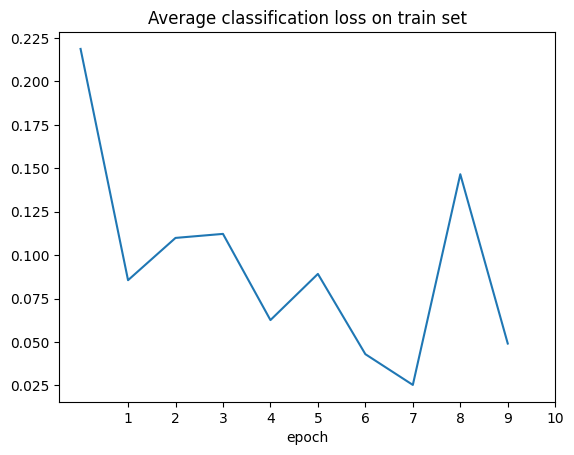

In [47]:
# avg class loss on train set
plt.plot(train_avg_class_losses)
plt.title('Average classification loss on train set')
plt.xticks(range(1,11))
plt.xlabel('epoch')
plt.savefig('02-graph/train_avg_class_loss.jpg')
plt.show()

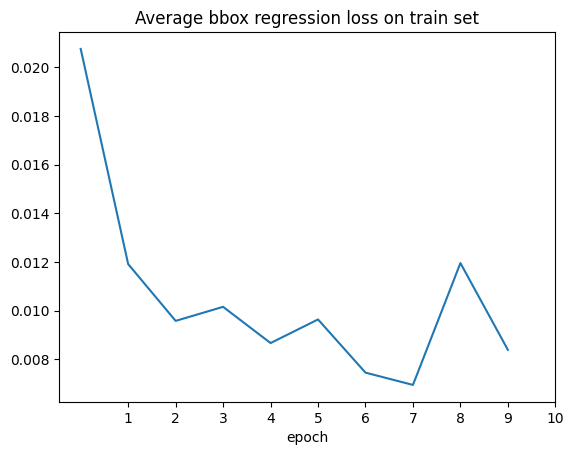

In [48]:
# avg box loss on train set
plt.plot(train_avg_box_losses)
plt.title('Average bbox regression loss on train set')
plt.xlabel('epoch')
plt.xticks(range(1,11))
plt.savefig('02-graph/train_avg_box_loss.jpg')
plt.show()

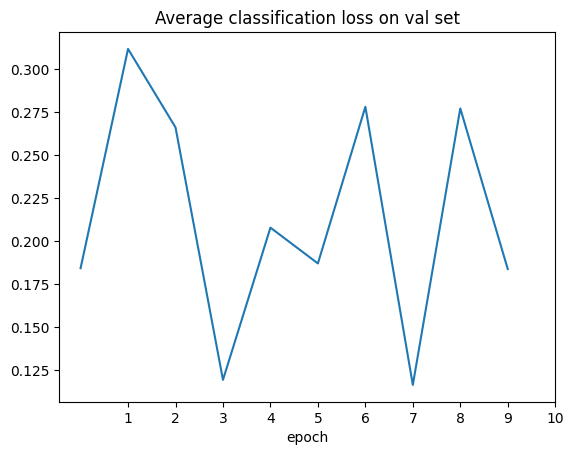

In [49]:
# avg class loss on val set
plt.plot(val_avg_class_losses)
plt.title('Average classification loss on val set')
plt.xlabel('epoch')
plt.xticks(range(1,11))
plt.savefig('02-graph/val_avg_class_loss.jpg')
plt.show()

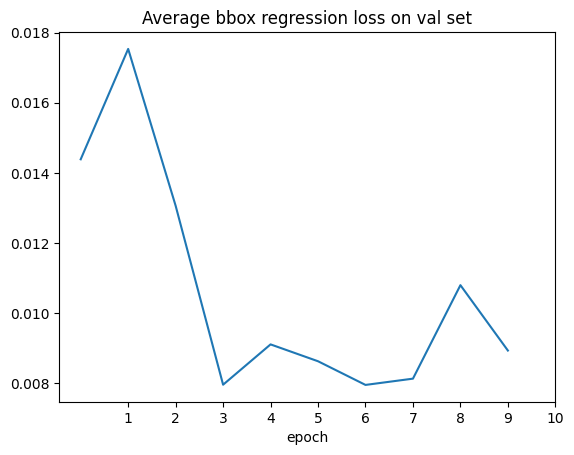

In [50]:
# avg box loss on val set
plt.plot(val_avg_box_losses)
plt.title('Average bbox regression loss on val set')
plt.xticks(range(1,11))
plt.xlabel('epoch')
plt.savefig('02-graph/val_avg_box_loss.jpg')
plt.show()

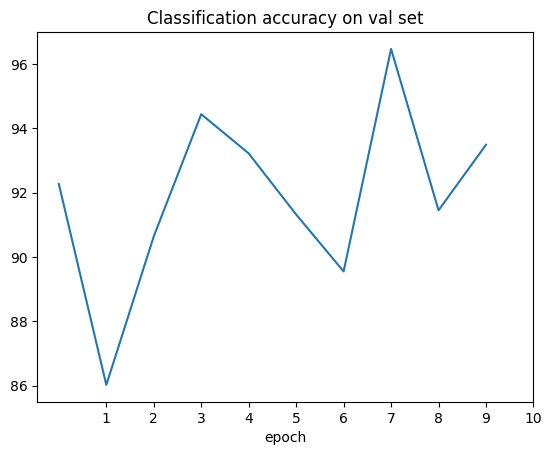

In [51]:
# accuracy on val set
plt.plot(val_accuracy)
plt.title('Classification accuracy on val set')
plt.xticks(range(1,11))
plt.xlabel('epoch')
plt.savefig('02-graph/val_accuracy.jpg')
plt.show()